In [28]:
# Get a profile of the results sheets

import pandas as pd
from pathlib import Path
from collections import defaultdict

# Define path to CSV files
csv_dir = Path('../source/csv_results')

# Dictionary to store column names for each file
column_dict = {}

# Read column names from each CSV
for csv_file in sorted(csv_dir.glob('*.csv')):
    df = pd.read_csv(csv_file, nrows=0)  # Read only headers
    column_dict[csv_file.name] = list(df.columns)
    print(f"{csv_file.name}: {len(df.columns)} columns")

print(f"\n{'='*60}")
print(f"Total CSV files analyzed: {len(column_dict)}")
print(f"{'='*60}")

# Check if all column sets are identical
all_columns = list(column_dict.values())
first_columns = all_columns[0]
all_identical = all(cols == first_columns for cols in all_columns)

if all_identical:
    print("\n✅ All CSV files have IDENTICAL column names!")
    print(f"\nColumn names ({len(first_columns)} columns):")
    for i, col in enumerate(first_columns, 1):
        print(f"  {i}. {col}")
else:
    print("\n⚠️  CSV files have DIFFERENT column names!")
    
    # Find unique column sets
    unique_column_sets = {}
    for filename, cols in column_dict.items():
        cols_tuple = tuple(cols)
        if cols_tuple not in unique_column_sets:
            unique_column_sets[cols_tuple] = []
        unique_column_sets[cols_tuple].append(filename)
    
    print(f"\nFound {len(unique_column_sets)} different column structures:\n")
    
    for i, (cols, files) in enumerate(unique_column_sets.items(), 1):
        print(f"\n--- Structure {i} ({len(cols)} columns) ---")
        print(f"Files with this structure: {', '.join(files)}")
        print(f"\nColumns:")
        for j, col in enumerate(cols, 1):
            print(f"  {j}. {col}")
    
    # Show differences between structures
    if len(unique_column_sets) == 2:
        print(f"\n{'='*60}")
        print("DIFF ANALYSIS")
        print(f"{'='*60}")
        
        cols_list = list(unique_column_sets.keys())
        set1, set2 = set(cols_list[0]), set(cols_list[1])
        
        only_in_first = set1 - set2
        only_in_second = set2 - set1
        common = set1 & set2
        
        print(f"\nCommon columns: {len(common)}")
        print(f"Only in structure 1: {len(only_in_first)}")
        if only_in_first:
            for col in only_in_first:
                print(f"  - {col}")
        
        print(f"\nOnly in structure 2: {len(only_in_second)}")
        if only_in_second:
            for col in only_in_second:
                print(f"  - {col}")


Athabasca_Results_Nov6_2024.csv: 56 columns
Calgary_Results_Oct23.csv: 56 columns
Concordia_Results_Oct24.csv: 56 columns
Laval_Results_Oct20.csv: 56 columns
Manitoba_Results_Oct23.csv: 56 columns
McGill-Queens_Results_Oct20.csv: 56 columns
Memorial_Final_Title_List.csv: 56 columns
Nunavut_Results_Oct24.csv: 60 columns
PIMS_Results_Oct23.csv: 56 columns
Regina_Results_Oct24.csv: 56 columns
Toronto_Results_Oct19.csv: 56 columns
UAlberta_Final_List_April1_2025.csv: 56 columns
UBC_Results_Oct23.csv: 56 columns
UMontreal_Results_Oct24.csv: 56 columns
UQuebec_Results_Oct24.csv: 56 columns
Wilfrid_Laurier_Results_Oct23_Revised.csv: 57 columns

Total CSV files analyzed: 16

⚠️  CSV files have DIFFERENT column names!

Found 3 different column structures:


--- Structure 1 (56 columns) ---
Files with this structure: Athabasca_Results_Nov6_2024.csv, Calgary_Results_Oct23.csv, Concordia_Results_Oct24.csv, Laval_Results_Oct20.csv, Manitoba_Results_Oct23.csv, McGill-Queens_Results_Oct20.csv, Memori

In [29]:
# Combine original results sheets into a single master sheet

import pandas as pd
from pathlib import Path
import warnings

# Define columns to extract
columns_to_extract = [
    'ID',
    'TITLE_AUTHOR_DATE_COMBINED_NORMALIZED',
    'TITLE',
    'TITLE_REMAINDER',
    'AUTHOR',
    'AUTHOR_QUALIFIER',
    'AUTHOR_DATE',
    'EDITION',
    'BEGIN_PUBLICATION_DATE',
    'PUBDATE_260',
    'PUBDATE_264',
    'PUBPLACE_260',
    'PUBPLACE_264',
    'PUBLISHER_260',
    'PUBLISHER_264',
    'EXTENT',
    'ASSOCIATED_ISBNS',
    'ASSOCIATED_OCLC_NUMBERS',
    'LCCN',
    'TITLE_MATCH_COUNT',
    'RETENTIONS_APPLIED'
]

# Define path to CSV files
csv_dir = Path('../source/csv_results')

# List to store dataframes
dfs_to_combine = []

print(f"Processing {len(list(csv_dir.glob('*.csv')))} CSV files...\n")

# Process each CSV file
for csv_file in sorted(csv_dir.glob('*.csv')):
    print(f"Processing: {csv_file.name}")
    
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Get available columns
    available_columns = df.columns.tolist()
    
    # Check which columns exist and which don't
    missing_columns = []
    present_columns = []
    
    for col in columns_to_extract:
        if col in available_columns:
            present_columns.append(col)
        else:
            missing_columns.append(col)
            warnings.warn(f"Column '{col}' not found in {csv_file.name}")
    
    # Extract only the columns that exist
    df_subset = df[present_columns].copy()
    
    # Add missing columns as NaN
    for col in missing_columns:
        df_subset[col] = None
    
    # Reorder columns to match the original list
    df_subset = df_subset[columns_to_extract]
    
    # Add source column (extract meaningful name from filename)
    source_name = csv_file.stem  # Remove .csv extension
    df_subset.insert(0, 'SOURCE_DATASET', source_name)
    
    print(f"  ✓ Extracted {len(df_subset)} rows, {len(present_columns)}/{len(columns_to_extract)} columns present")
    if missing_columns:
        print(f"  ⚠️  Missing columns: {', '.join(missing_columns)}")
    
    dfs_to_combine.append(df_subset)

print(f"\n{'='*60}")
print("Combining all datasets...")

# Combine all dataframes vertically
combined_df = pd.concat(dfs_to_combine, axis=0, ignore_index=True)

print(f"✓ Combined dataset shape: {combined_df.shape[0]:,} rows × {combined_df.shape[1]} columns")

# Save to CSV (disabled unless required)
# output_path = Path('../source/combined_results.csv')
# combined_df.to_csv(output_path, index=False)

#print(f"✓ Saved to: {output_path}")
print(f"\n{'='*60}")
print("Summary by source:")
print(combined_df['SOURCE_DATASET'].value_counts().sort_index())
print(f"{'='*60}")


Processing 16 CSV files...

Processing: Athabasca_Results_Nov6_2024.csv
  ✓ Extracted 225 rows, 21/21 columns present
Processing: Calgary_Results_Oct23.csv
  ✓ Extracted 595 rows, 21/21 columns present
Processing: Concordia_Results_Oct24.csv
  ✓ Extracted 187 rows, 21/21 columns present
Processing: Laval_Results_Oct20.csv
  ✓ Extracted 5787 rows, 21/21 columns present
Processing: Manitoba_Results_Oct23.csv
  ✓ Extracted 386 rows, 21/21 columns present
Processing: McGill-Queens_Results_Oct20.csv
  ✓ Extracted 7982 rows, 21/21 columns present
Processing: Memorial_Final_Title_List.csv
  ✓ Extracted 253 rows, 21/21 columns present
Processing: Nunavut_Results_Oct24.csv
  ✓ Extracted 100 rows, 21/21 columns present
Processing: PIMS_Results_Oct23.csv
  ✓ Extracted 1242 rows, 21/21 columns present
Processing: Regina_Results_Oct24.csv
  ✓ Extracted 809 rows, 21/21 columns present
Processing: Toronto_Results_Oct19.csv
  ✓ Extracted 9451 rows, 21/21 columns present
Processing: UAlberta_Final_List

Aggregate Statistics by Source Dataset:
                       Source Dataset  Record Count  Total Title Matches  Total Retentions Applied  Avg Fuzzy Matches per Title
          Athabasca_Results_Nov6_2024           225                 1234                       555                     5.484444
                Calgary_Results_Oct23           595                 4543                      1671                     7.635294
              Concordia_Results_Oct24           187                  296                       276                     1.582888
                  Laval_Results_Oct20          5787                27492                     13673                     4.750648
               Manitoba_Results_Oct23           386                 2403                       961                     6.225389
          McGill-Queens_Results_Oct20          7982                38913                     16467                     4.875094
            Memorial_Final_Title_List           253             

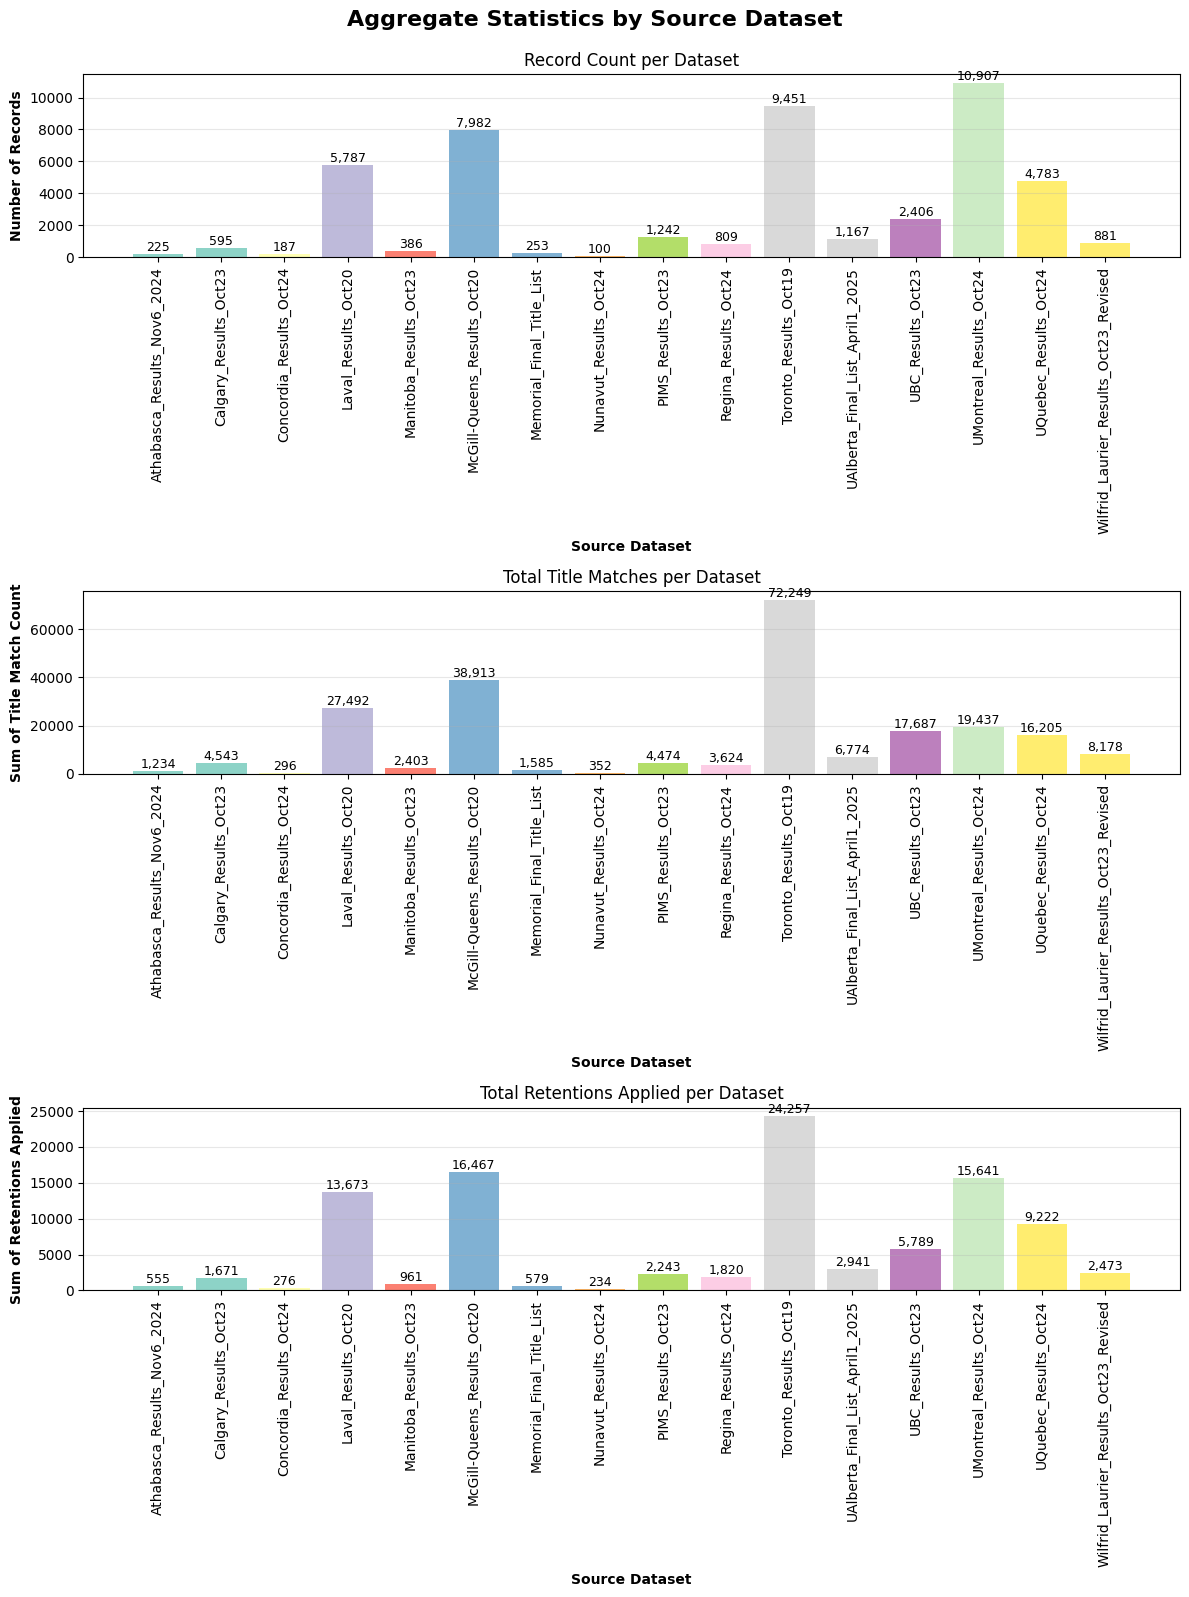

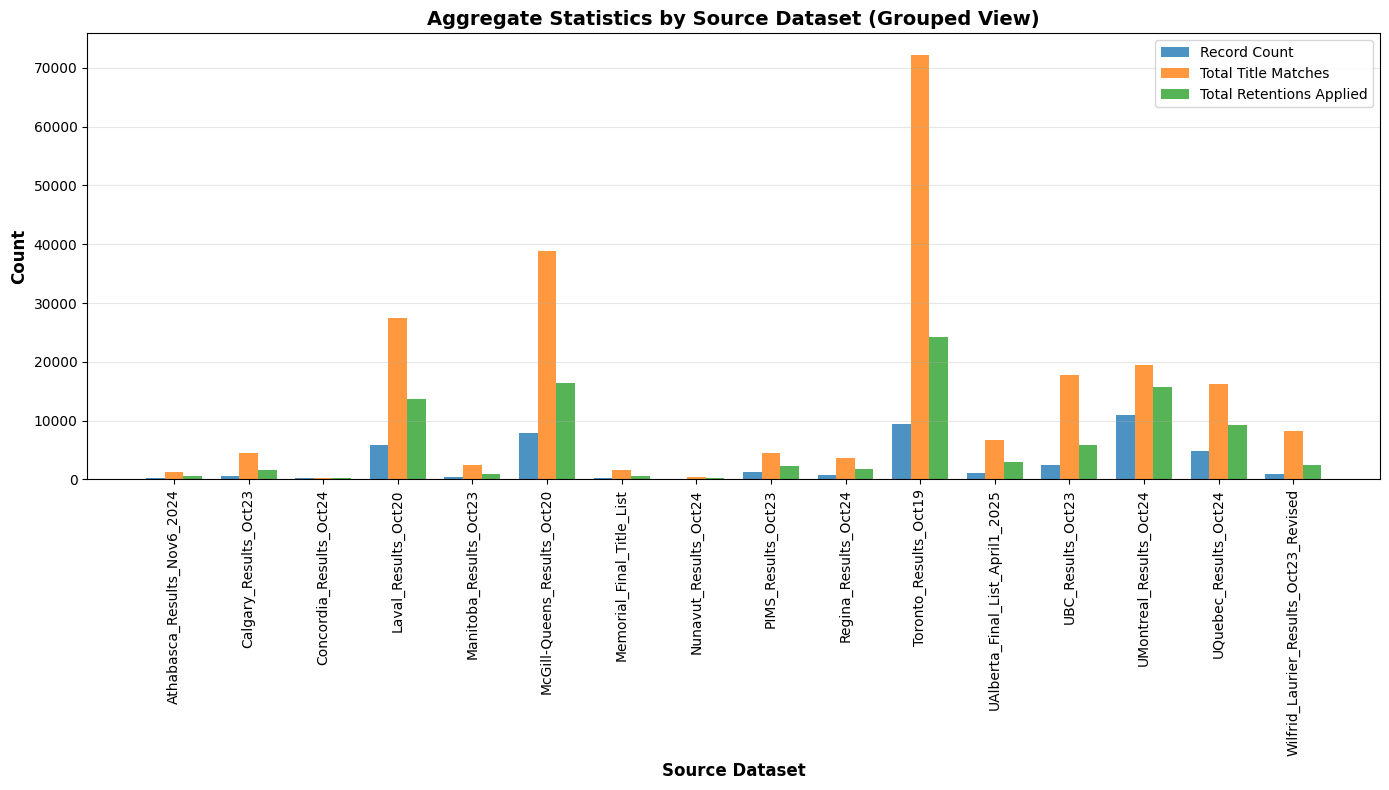

In [30]:
# Visualize aggregate statistics by source dataset

import matplotlib.pyplot as plt
import numpy as np

# Aggregate statistics by source dataset
agg_stats = combined_df.groupby('SOURCE_DATASET').agg({
    'ID': 'count',  # Number of records
    'TITLE_MATCH_COUNT': 'sum',  # Sum of title matches
    'RETENTIONS_APPLIED': 'sum'  # Sum of retentions applied
}).reset_index()

# Rename columns for clarity
agg_stats.columns = ['Source Dataset', 'Record Count', 'Total Title Matches', 'Total Retentions Applied']

# Add ratio column: Fuzzy Matches per Title
agg_stats['Avg Fuzzy Matches per Title'] = agg_stats['Total Title Matches'] / agg_stats['Record Count']

print("Aggregate Statistics by Source Dataset:")
print("="*100)
print(agg_stats.to_string(index=False))
print("="*100)

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
fig.suptitle('Aggregate Statistics by Source Dataset', fontsize=16, fontweight='bold', y=0.995)

# Color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(agg_stats)))

# Chart 1: Record Count
ax1 = axes[0]
bars1 = ax1.bar(agg_stats['Source Dataset'], agg_stats['Record Count'], color=colors)
ax1.set_xlabel('Source Dataset', fontweight='bold')
ax1.set_ylabel('Number of Records', fontweight='bold')
ax1.set_title('Record Count per Dataset')
ax1.tick_params(axis='x', rotation=90)
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

# Chart 2: Total Title Matches
ax2 = axes[1]
bars2 = ax2.bar(agg_stats['Source Dataset'], agg_stats['Total Title Matches'], color=colors)
ax2.set_xlabel('Source Dataset', fontweight='bold')
ax2.set_ylabel('Sum of Title Match Count', fontweight='bold')
ax2.set_title('Total Title Matches per Dataset')
ax2.tick_params(axis='x', rotation=90)
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

# Chart 3: Total Retentions Applied
ax3 = axes[2]
bars3 = ax3.bar(agg_stats['Source Dataset'], agg_stats['Total Retentions Applied'], color=colors)
ax3.set_xlabel('Source Dataset', fontweight='bold')
ax3.set_ylabel('Sum of Retentions Applied', fontweight='bold')
ax3.set_title('Total Retentions Applied per Dataset')
ax3.tick_params(axis='x', rotation=90)
ax3.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Optional: Create a single grouped bar chart as an alternative view
fig2, ax = plt.subplots(figsize=(14, 8))

# Prepare data for grouped bar chart
x = np.arange(len(agg_stats))
width = 0.25

# Normalize the values for better comparison (each metric on its own scale)
record_count_norm = agg_stats['Record Count']
title_matches_norm = agg_stats['Total Title Matches']
retentions_norm = agg_stats['Total Retentions Applied']

# Create bars
bars1 = ax.bar(x - width, record_count_norm, width, label='Record Count', alpha=0.8)
bars2 = ax.bar(x, title_matches_norm, width, label='Total Title Matches', alpha=0.8)
bars3 = ax.bar(x + width, retentions_norm, width, label='Total Retentions Applied', alpha=0.8)

# Customize chart
ax.set_xlabel('Source Dataset', fontweight='bold', fontsize=12)
ax.set_ylabel('Count', fontweight='bold', fontsize=12)
ax.set_title('Aggregate Statistics by Source Dataset (Grouped View)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(agg_stats['Source Dataset'], rotation=90, ha='center')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [31]:
# Find duplicate records within each source dataset
# Based on TITLE_AUTHOR_DATE_COMBINED_NORMALIZED column

import pandas as pd

# List to store all duplicate records
all_duplicates = []

# Get unique source datasets
source_datasets = combined_df['SOURCE_DATASET'].unique()

print("Searching for duplicates in TITLE_AUTHOR_DATE_COMBINED_NORMALIZED by source dataset...\n")
print("="*100)

for source in sorted(source_datasets):
    # Filter data for this source
    source_data = combined_df[combined_df['SOURCE_DATASET'] == source].copy()
    
    # Find duplicates based on TITLE_AUTHOR_DATE_COMBINED_NORMALIZED
    # Keep all occurrences (not just the duplicates)
    duplicated_mask = source_data.duplicated(subset=['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'], keep=False)
    
    # Get the duplicate records
    duplicates = source_data[duplicated_mask].copy()
    
    if len(duplicates) > 0:
        print(f"\n{source}:")
        print(f"  Found {len(duplicates)} duplicate records in {duplicates['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'].nunique()} unique groups")
        
        # Sort by the normalized column to group duplicates together
        duplicates_sorted = duplicates.sort_values('TITLE_AUTHOR_DATE_COMBINED_NORMALIZED')
        
        # Display the duplicates with ID and source
        for idx, (norm_value, group) in enumerate(duplicates_sorted.groupby('TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'), 1):
            print(f"\n  Duplicate Group {idx}: '{norm_value}'")
            for _, row in group.iterrows():
                print(f"    - ID: {row['ID']}, Source: {row['SOURCE_DATASET']}")
        
        # Add to the full list
        all_duplicates.append(duplicates[['SOURCE_DATASET', 'ID', 'TITLE_AUTHOR_DATE_COMBINED_NORMALIZED', 'TITLE', 'AUTHOR']])
    else:
        print(f"\n{source}: No duplicates found")

print("\n" + "="*100)

# Combine all duplicates into a single dataframe
if all_duplicates:
    duplicates_df = pd.concat(all_duplicates, ignore_index=True)
    print(f"\n✓ Total duplicate records found: {len(duplicates_df)}")
    print(f"✓ Across {duplicates_df['SOURCE_DATASET'].nunique()} source datasets")
    print(f"✓ In {duplicates_df['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'].nunique()} unique duplicate groups")
    
    # Display summary
    print("\n" + "="*100)
    print("SUMMARY OF DUPLICATES BY SOURCE DATASET:")
    print("="*100)
    summary = duplicates_df.groupby('SOURCE_DATASET').agg({
        'ID': 'count',
        'TITLE_AUTHOR_DATE_COMBINED_NORMALIZED': 'nunique'
    }).reset_index()
    summary.columns = ['Source Dataset', 'Duplicate Records', 'Unique Duplicate Groups']
    print(summary.to_string(index=False))
    
    # Save to variable for further analysis
    print("\n✓ Duplicate records saved to 'duplicates_df' dataframe")
else:
    print("\n✓ No duplicates found in any source dataset")


Searching for duplicates in TITLE_AUTHOR_DATE_COMBINED_NORMALIZED by source dataset...


Athabasca_Results_Nov6_2024: No duplicates found

Calgary_Results_Oct23: No duplicates found

Concordia_Results_Oct24: No duplicates found

Laval_Results_Oct20: No duplicates found

Manitoba_Results_Oct23: No duplicates found

McGill-Queens_Results_Oct20: No duplicates found

Memorial_Final_Title_List: No duplicates found

Nunavut_Results_Oct24: No duplicates found

PIMS_Results_Oct23: No duplicates found

Regina_Results_Oct24: No duplicates found

Toronto_Results_Oct19: No duplicates found

UAlberta_Final_List_April1_2025:
  Found 2 duplicate records in 1 unique groups

  Duplicate Group 1: 'enduringpowersofattorney--1990'
    - ID: 426, Source: UAlberta_Final_List_April1_2025
    - ID: 426, Source: UAlberta_Final_List_April1_2025

UBC_Results_Oct23: No duplicates found

UMontreal_Results_Oct24: No duplicates found

UQuebec_Results_Oct24: No duplicates found

Wilfrid_Laurier_Results_Oct23_Revised:

In [32]:
# Fuzzy similarity matching within each source dataset
# Find records with 90%+ similarity in TITLE_AUTHOR_DATE_COMBINED_NORMALIZED
# The filter logic:
## Extracts and strips the BEGIN_PUBLICATION_DATE values from both records
## If both values exist (are not empty) AND they are equal, the match is retained
## If the dates are different, or if one/both are missing, the match is excluded from the results
# The intention is to catch matches that are the same title, author, and publication date.

import pandas as pd
from rapidfuzz import fuzz
from itertools import combinations
import warnings

# Suppress potential warnings
warnings.filterwarnings('ignore')

# List to store fuzzy match results
fuzzy_matches = []

# Get unique source datasets
source_datasets = combined_df['SOURCE_DATASET'].unique()

print("Performing fuzzy similarity analysis on TITLE_AUTHOR_DATE_COMBINED_NORMALIZED...")
print("Minimum similarity threshold: 90%\n")
print("="*120)

for source in sorted(source_datasets):
    # Filter data for this source
    source_data = combined_df[combined_df['SOURCE_DATASET'] == source].copy()
    
    # Remove rows with null/empty normalized values
    source_data = source_data.dropna(subset=['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'])
    source_data = source_data[source_data['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'].str.strip() != '']
    
    print(f"\nProcessing: {source} ({len(source_data)} records)")
    
    # Convert to list for comparison
    records = source_data.to_dict('records')
    
    # Compare all pairs
    matches_found = 0
    for i, record1 in enumerate(records):
        for j, record2 in enumerate(records):
            if i < j:  # Only compare each pair once
                str1 = str(record1['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'])
                str2 = str(record2['TITLE_AUTHOR_DATE_COMBINED_NORMALIZED'])
                
                # Skip if strings are identical (already caught by exact duplicate check)
                if str1 == str2:
                    continue
                
                # Calculate similarity score using token_sort_ratio (good for handling word order variations)
                similarity = fuzz.token_sort_ratio(str1, str2)
                
                # If similarity >= 90%, check publication date filter
                if similarity >= 90:
                    # Only include matches where BEGIN_PUBLICATION_DATE values ARE equal
                    pubdate1 = str(record1.get('BEGIN_PUBLICATION_DATE', '')).strip()
                    pubdate2 = str(record2.get('BEGIN_PUBLICATION_DATE', '')).strip()
                    
                    # Skip if publication dates are different or if either is empty
                    if not pubdate1 or not pubdate2 or pubdate1 != pubdate2:
                        continue
                    
                    matches_found += 1
                    fuzzy_matches.append({
                        'SOURCE_DATASET': source,
                        'ID_1': record1['ID'],
                        'ID_2': record2['ID'],
                        'NORMALIZED_1': str1,
                        'NORMALIZED_2': str2,
                        'TITLE_1': record1['TITLE'],
                        'TITLE_2': record2['TITLE'],
                        'AUTHOR_1': record1['AUTHOR'],
                        'AUTHOR_2': record2['AUTHOR'],
                        'BEGIN_PUBLICATION_DATE_1': pubdate1,
                        'BEGIN_PUBLICATION_DATE_2': pubdate2,
                        'SIMILARITY_SCORE': similarity
                    })
    
    print(f"  Found {matches_found} fuzzy matches (90%+ similarity)")

print("\n" + "="*120)

# Create dataframe from results
if fuzzy_matches:
    fuzzy_matches_df = pd.DataFrame(fuzzy_matches)
    
    # Sort by similarity score (descending) and source dataset
    fuzzy_matches_df = fuzzy_matches_df.sort_values(['SOURCE_DATASET', 'SIMILARITY_SCORE'], 
                                                      ascending=[True, False])
    
    print(f"\n✓ Total fuzzy matches found: {len(fuzzy_matches_df)}")
    print(f"✓ Across {fuzzy_matches_df['SOURCE_DATASET'].nunique()} source datasets")
    
    # Display summary by source
    print("\n" + "="*120)
    print("SUMMARY OF FUZZY MATCHES BY SOURCE DATASET:")
    print("="*120)
    summary = fuzzy_matches_df.groupby('SOURCE_DATASET').agg({
        'SIMILARITY_SCORE': ['count', 'mean', 'min', 'max']
    }).reset_index()
    summary.columns = ['Source Dataset', 'Match Count', 'Avg Similarity', 'Min Similarity', 'Max Similarity']
    summary['Avg Similarity'] = summary['Avg Similarity'].round(2)
    print(summary.to_string(index=False))
    
    # Save fuzzy matches to CSV file
    output_path = '../output/fuzzy_matches.csv'
    fuzzy_matches_df.to_csv(output_path, index=False)
    print(f"\n✓ Fuzzy matches saved to: {output_path}")
    
    # Save to variable for further analysis
    print("\n" + "="*120)
    print("✓ Fuzzy match results saved to 'fuzzy_matches_df' dataframe")
    
else:
    print("\n✓ No fuzzy matches found with 90%+ similarity in any source dataset")


Performing fuzzy similarity analysis on TITLE_AUTHOR_DATE_COMBINED_NORMALIZED...
Minimum similarity threshold: 90%


Processing: Athabasca_Results_Nov6_2024 (225 records)
  Found 0 fuzzy matches (90%+ similarity)

Processing: Calgary_Results_Oct23 (595 records)
  Found 0 fuzzy matches (90%+ similarity)

Processing: Concordia_Results_Oct24 (187 records)
  Found 6 fuzzy matches (90%+ similarity)

Processing: Laval_Results_Oct20 (5787 records)
  Found 68 fuzzy matches (90%+ similarity)

Processing: Manitoba_Results_Oct23 (386 records)
  Found 3 fuzzy matches (90%+ similarity)

Processing: McGill-Queens_Results_Oct20 (7982 records)
  Found 48 fuzzy matches (90%+ similarity)

Processing: Memorial_Final_Title_List (253 records)
  Found 0 fuzzy matches (90%+ similarity)

Processing: Nunavut_Results_Oct24 (100 records)
  Found 7 fuzzy matches (90%+ similarity)

Processing: PIMS_Results_Oct23 (1242 records)
  Found 7 fuzzy matches (90%+ similarity)

Processing: Regina_Results_Oct24 (809 records